# AttackNet Training

## Step 1. Preparation

### 1.1. Importing needed packages

In [13]:
# Default imports
import logging, sys
from pathlib import Path
from typing import Dict, Any

# Numpy imports
import numpy as np
import pickle

# ML & CV imports
import tensorflow as tf
from matplotlib import pyplot as plt

### 1.2. Helper functions with logging

In [2]:
from importlib import reload
from IPython.display import display, Markdown

reload(logging)
logging.basicConfig(stream=sys.stdout, format='',
                    level=logging.INFO, datefmt=None)
log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def display_header(text: str) -> None:
    """
    Display a header 
    """
    display(Markdown(f'### {text}'))


#### 1.3. Helper functions for showing images

In [19]:
def show_images(X: np.ndarray, y: np.ndarray, size: tuple = (9,9)) -> None:
    """
    Helper function displaying a set of specified images and their labels
    """
    assert len(X) == len(y), "X and y must have the same shapes"
    n = len(X)

    rows = int(np.sqrt(n))
    cols = n // rows

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=size)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(X[i], cmap='gray')
        ax.set_title(f'Number {y[i]}')

    fig.tight_layout()
    plt.show()

## Step 2. Define the AttackNet architecture

In [4]:
class AttackNet:
    def __init__(self, hyperparams: Dict[str, Any]) -> None:
        """
        Function that initializes the AttackNet model
        
        Args:
            hyperparams (Dict[str, Any]): Dictionary containing hyperparameters for the model
        """
        
        self._hyperparams = hyperparams
        self._model = self._generate_model()
        
    def _generate_model(self) -> tf.keras.models.Model:
        """
        Function generating a model based on self._hyperparams
        """
        
        channel_dimension = -1 # feature map channel
    
        # First convolutional phase
        input_layer = tf.keras.layers.Input(self._hyperparams['input_shape'])
        y = tf.keras.layers.Conv2D(16, 3, padding = 'same')(input_layer)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
        x = tf.keras.layers.BatchNormalization(axis=channel_dimension)(x)
        x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(x)
        z = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.add([y,z])
        x = tf.keras.layers.BatchNormalization(axis=channel_dimension)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)
    
        # Second convolutional phase
        y = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
        x = tf.keras.layers.BatchNormalization( axis=channel_dimension)(x)
        x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
        x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
        z = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.add([y,z])
        x = tf.keras.layers.BatchNormalization(axis=channel_dimension)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)
    
        # Dense phase
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation = 'tanh')(x)
        x = tf.keras.layers.BatchNormalization(axis=channel_dimension)(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        # Softmax layer (aka an output layer) 
        output_layer = tf.keras.layers.Dense(2, activation = 'softmax')(x)
    
        return tf.keras.models.Model(input_layer, output_layer)
    
    def train(
            self, 
            generator: tf.keras.utils.Sequence,
            show_history: bool = False
    ) -> tf.keras.callbacks.History:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hyperparams['learning_rate'])
        
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10),
        ]
        
        self._model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
        
        history = self._model.fit(
            generator,
            validation_data = (X_train, y_train),
            callbacks=callbacks,
            epochs=hyperparams['epochs']
        )
        if show_history:
            self._show_history(history)
        
        return history
    
    def _show_history(self, history: tf.keras.callbacks.History) -> None:
        # Defining styles
        plt.style.use('seaborn-v0_8-white')
        font = {'family' : 'serif',
                'weight' : 'normal',
                'size'   : 12}
        plt.rc('font', **font)
        plt.rc('axes', labelsize=16)
        plt.figure(figsize=(12,7), dpi=200)
        plt.grid()
        
        epochs_number = len(history.history['loss'])
        plt.plot(
            np.arange(0, epochs_number), 
            history.history["loss"], 
            color='r', linestyle='--', label="Training Loss")
        plt.plot(
            np.arange(0, epochs_number), 
            history.history["val_loss"], 
            color='b', linestyle='--', label="Validation Loss")
        plt.plot(
            np.arange(0, epochs_number), 
            history.history["accuracy"], 
            color='r', label="Training Accuracy")
        plt.plot(
            np.arange(0, epochs_number), 
            history.history["val_accuracy"], 
            color='b', label="Validation Accuracy")
        plt.title(f"Training Loss and Accuracy on {hyperparams['training_dataset']} Dataset")
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc="lower left")
        plt.savefig(f"results/{hyperparams['training_dataset']}.png")
        
    def save(self, path: Path):
        # Saving the model
        tf.keras.models.save_model(self._model, filepath=path, overwrite=True)

    def unwrap(self) -> tf.keras.Model:
        return self._model

In [5]:
# Defining the hyperparams that will be used during the training session
hyperparams = {
    'training_dataset': 'CSMAD',
    'input_shape': (32, 32, 3),
    'batch_size': 32,
    'learning_rate': 1e-5,
    'epochs': 150,
    'use_augmentation': True,
    'model_path': 'models/model_CSMAD.keras'
}

## Step 3. Preparing the dataset

### 3.1. Loading the dataset and displaying example images

In [17]:
TRAINING_SET = Path('datasets/csmad')
TRAINING_SET_LABELS = Path('datasets/csmad_labels')

(X_train, X_test, y_train, y_test) = pickle.loads(open(TRAINING_SET, "rb").read())

X_train = X_train[...,:3]
X_test = X_test[...,:3]

print(f'Loaded {len(X_train)} train images')
print(f'Loaded {len(X_test)} test images')
print(f'Image shape is {X_train.shape}')

Loaded 1632 train images
Loaded 816 test images
Image shape is (1632, 32, 32, 3)


### Training set

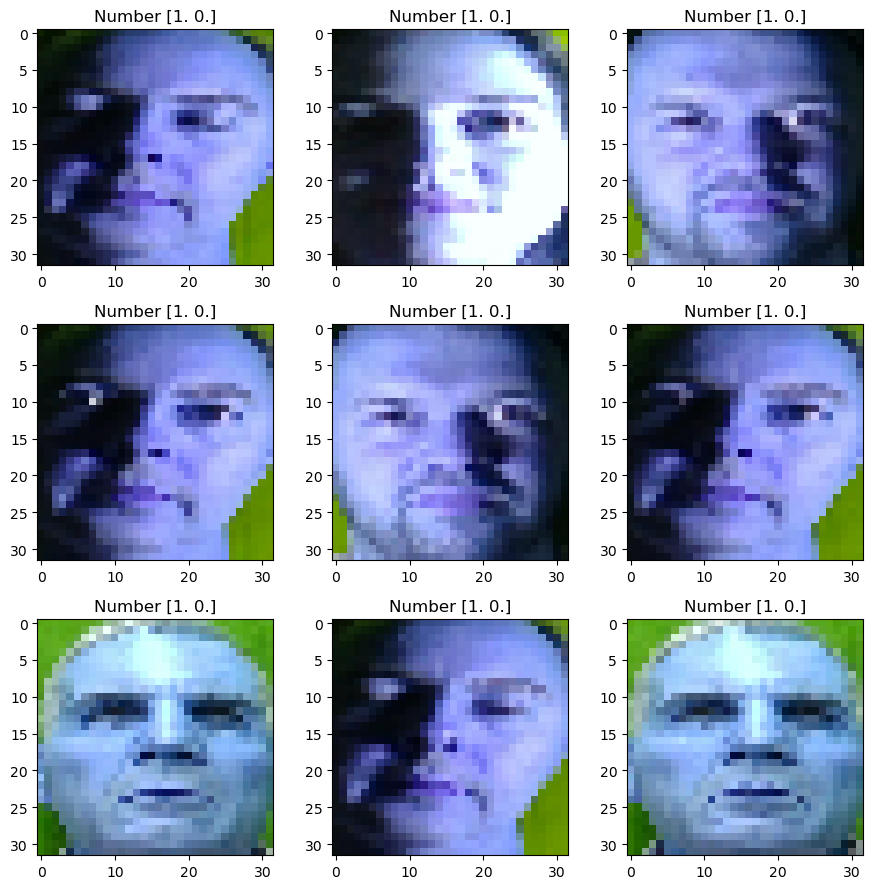

### Testing set

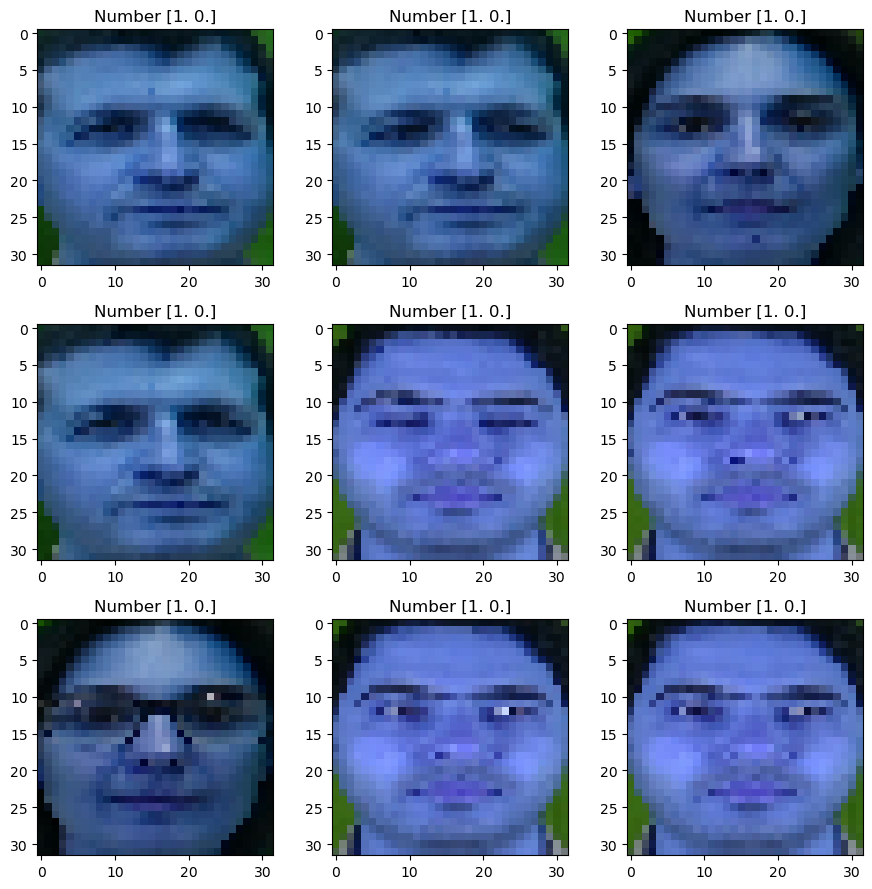

In [20]:
IMAGES_TO_SHOW = 9
display_header('Training set')
show_images(X_train[:IMAGES_TO_SHOW], y_train[:IMAGES_TO_SHOW], size=(9,9))
display_header('Testing set')
show_images(X_test[:IMAGES_TO_SHOW], y_test[:IMAGES_TO_SHOW], size=(9,9))

### Step 3.2. Adding online augmentation

In [21]:
# The random seed for online augmentation
augmentation_seed=10

# Online augmentation of training images
augmentation_training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.25,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.15,
    horizontal_flip=True, 
    fill_mode="constant"
)

# Output an endless Iterator of batches.
# Shuffle images, so the first generated batch is from batch_size random training images
augmentation_generator=augmentation_training.flow(
    X_train, 
    y_train, 
    batch_size=hyperparams['batch_size'], 
    shuffle=True, 
    seed=augmentation_seed
)

# Will be equal to np.ceil(len(train(X))/batch_size)
# Notice: if len(trainX) / batch_size is a float value, the last batch will contain less images than a batch_size value
print(f"Length of training batches is {len(augmentation_generator)}")

Length of training batches is 51


#### Displaying an example of using augmentation

### Using augmentation example

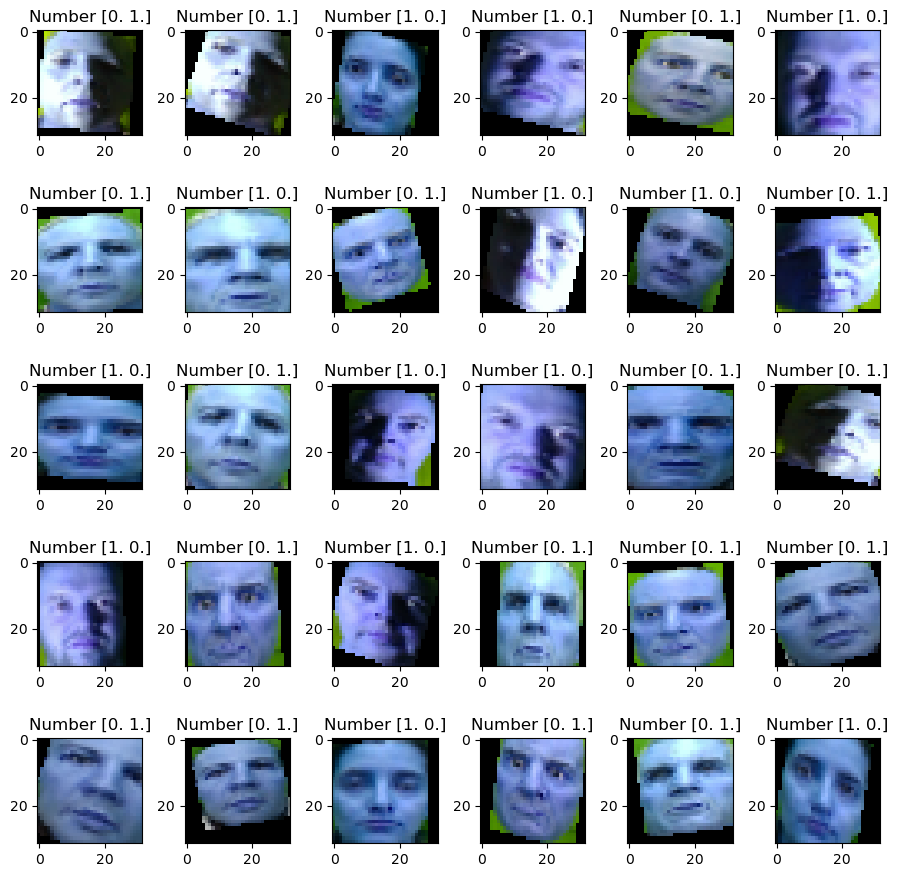

In [22]:
# We generate batch_size images, beginning from the first batch
X_batch, y_batch = next(augmentation_generator)
augmentation_example_images = [X_batch[i] for i in range(X_batch.shape[0])]
augmentation_generator.reset() # Once an epoch ends, this function will be called to reset data

display_header('Using augmentation example')
show_images(augmentation_example_images[:36], y_batch[:36])

## Step 4. Launching the training session 

Epoch 1/150
51/51 [==============================] - 2s 37ms/step - loss: 1.2019 - accuracy: 0.5453 - val_loss: 0.6904 - val_accuracy: 0.4773
Epoch 2/150
51/51 [==============================] - 2s 35ms/step - loss: 1.2501 - accuracy: 0.5411 - val_loss: 0.7680 - val_accuracy: 0.4412
Epoch 3/150
51/51 [==============================] - 2s 35ms/step - loss: 1.1573 - accuracy: 0.5582 - val_loss: 0.9132 - val_accuracy: 0.5000
Epoch 4/150
51/51 [==============================] - 2s 37ms/step - loss: 1.0622 - accuracy: 0.5925 - val_loss: 1.0884 - val_accuracy: 0.5000
Epoch 5/150
51/51 [==============================] - 3s 58ms/step - loss: 0.9600 - accuracy: 0.6127 - val_loss: 1.1747 - val_accuracy: 0.5000
Epoch 6/150
51/51 [==============================] - 2s 38ms/step - loss: 0.9552 - accuracy: 0.6201 - val_loss: 1.0113 - val_accuracy: 0.5000
Epoch 7/150
51/51 [==============================] - 2s 42ms/step - loss: 0.9334 - accuracy: 0.6532 - val_loss: 0.7509 - val_accuracy: 0.5527
Epoch 

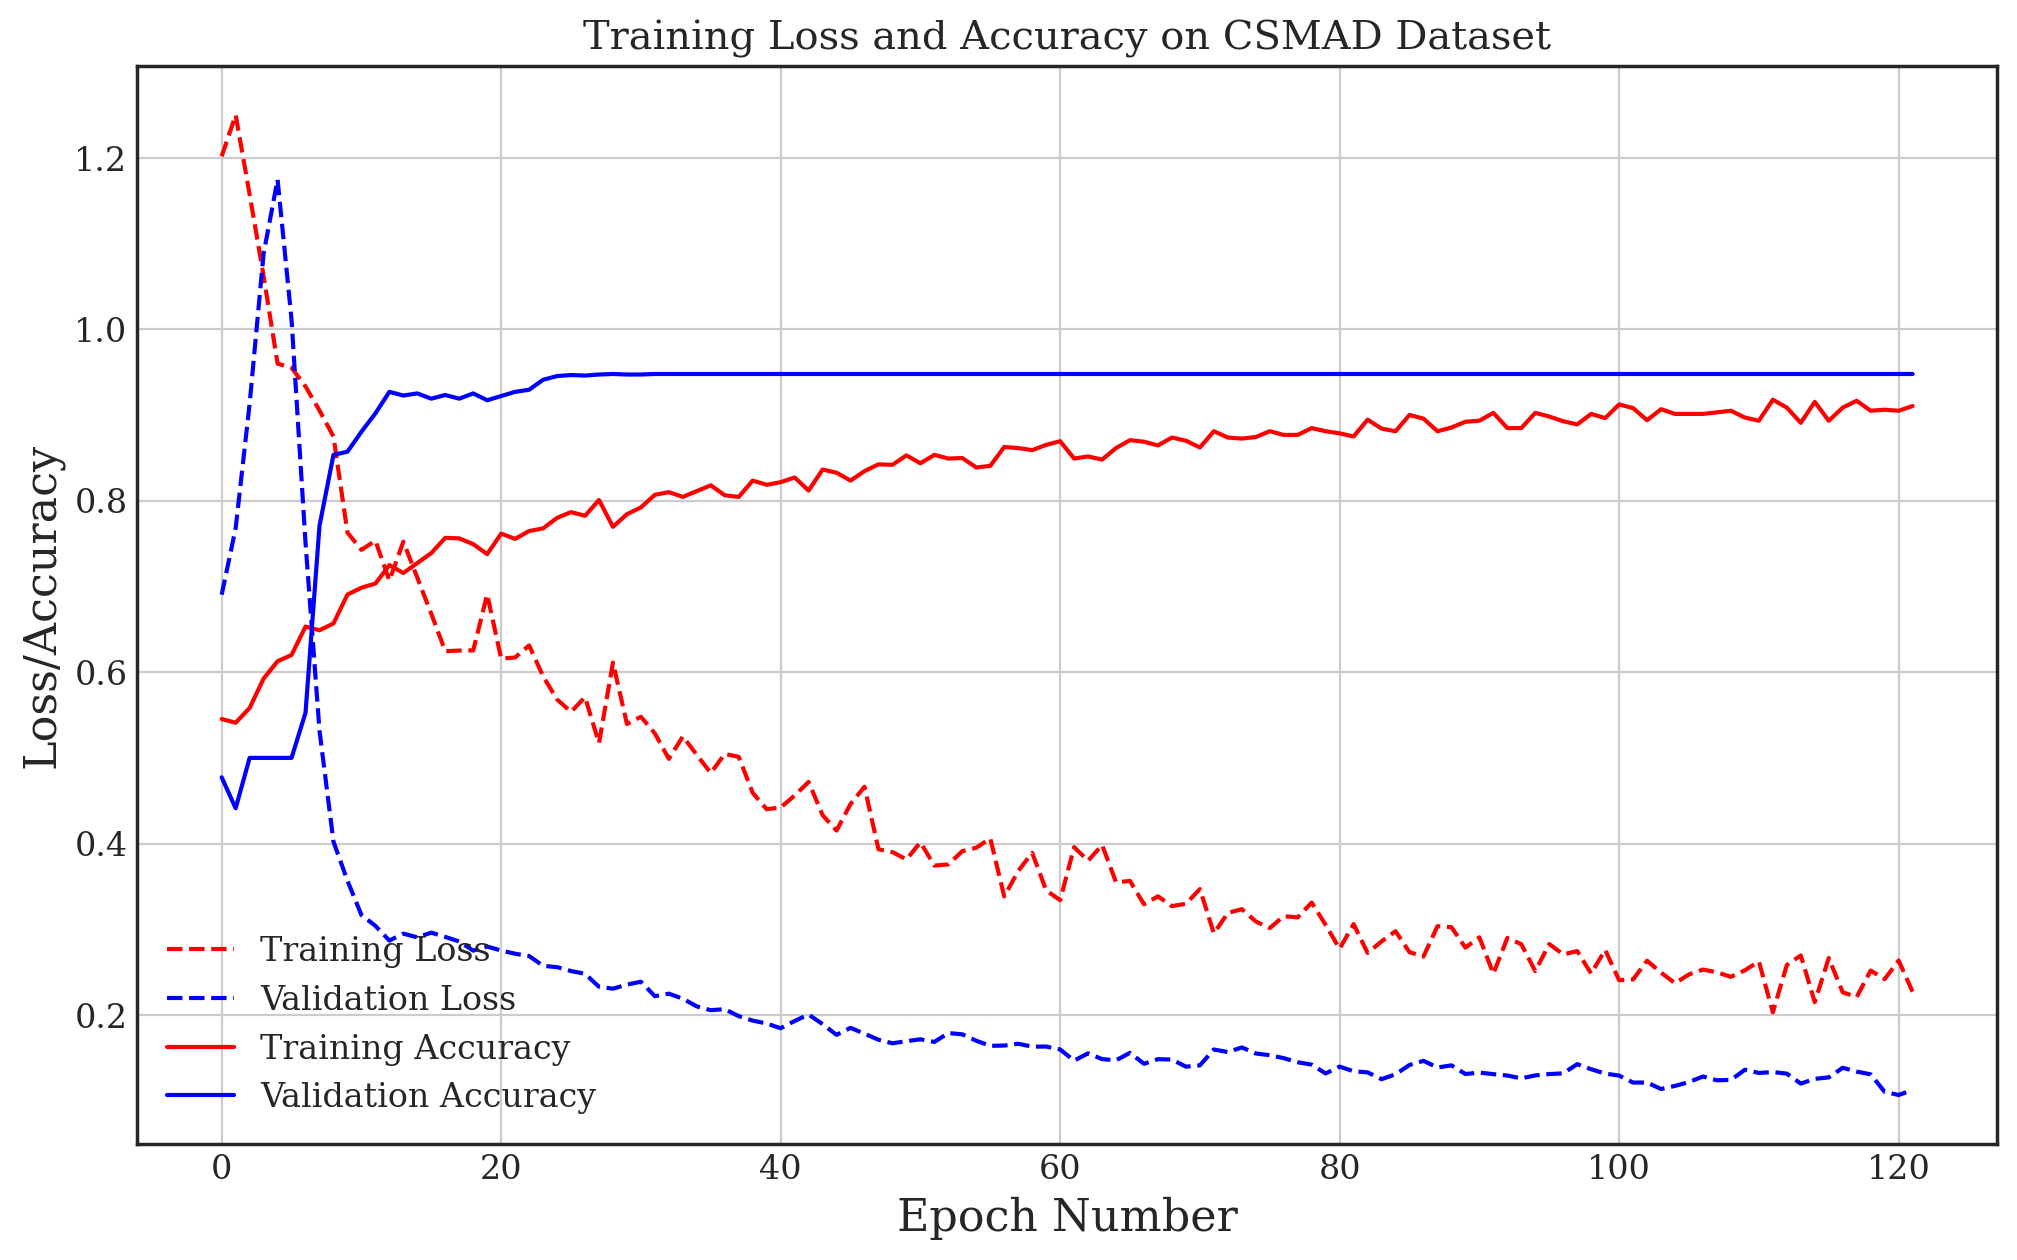

In [23]:
attacknet = AttackNet(hyperparams)
history = attacknet.train(augmentation_generator, show_history=True)

In [24]:
attacknet.save(hyperparams['model_path'])

## Step 5. Evaluating the model

26/26 [==============================] - 0s 8ms/step


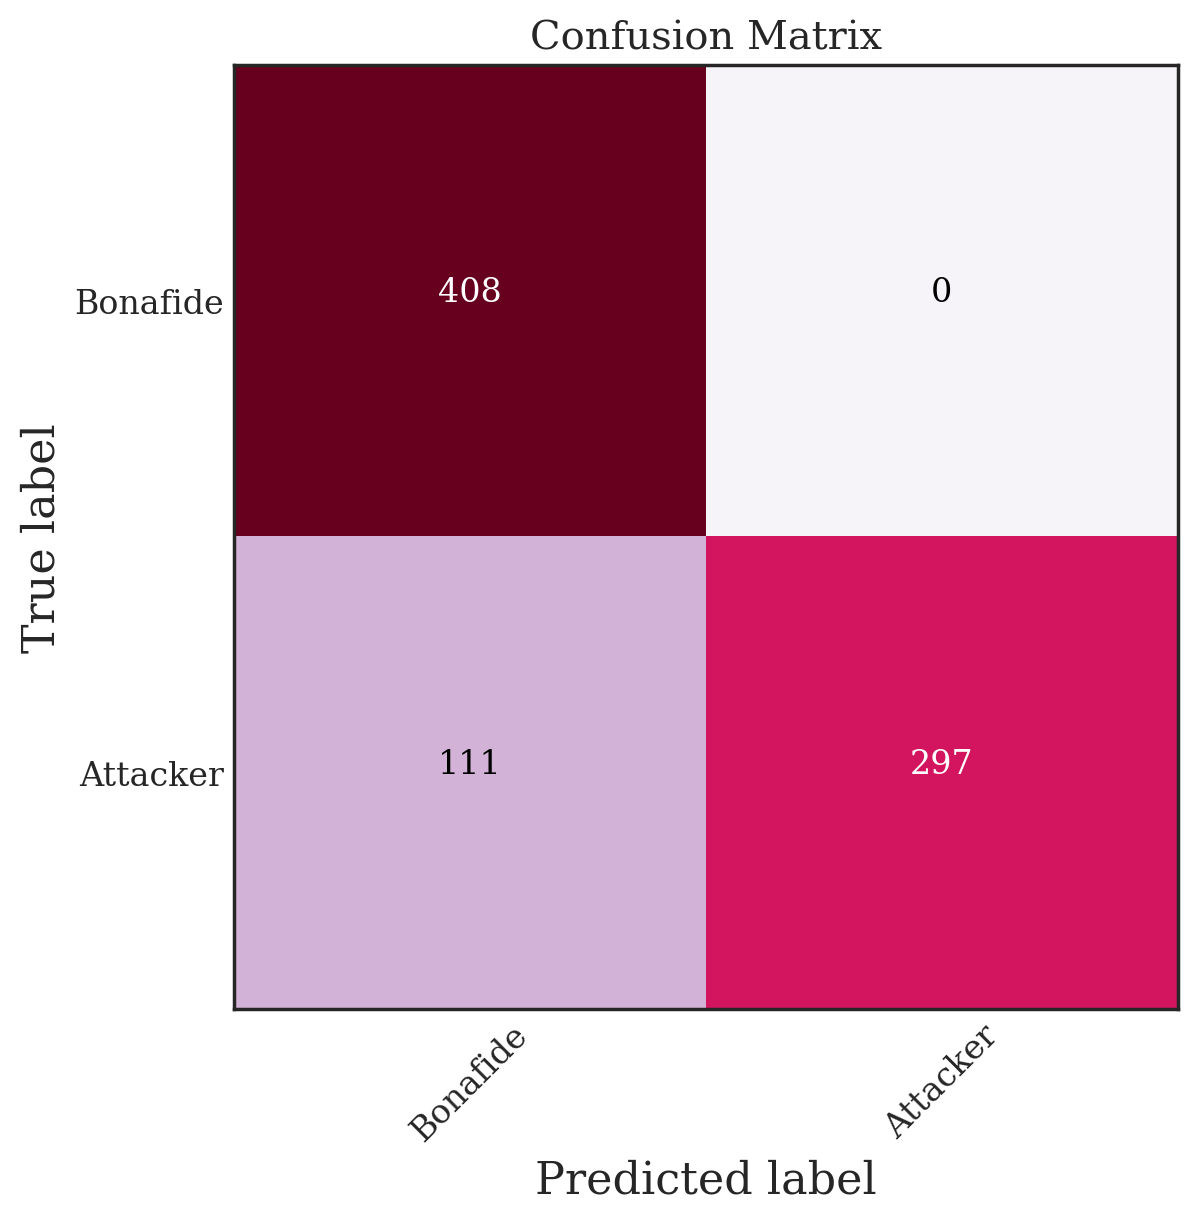

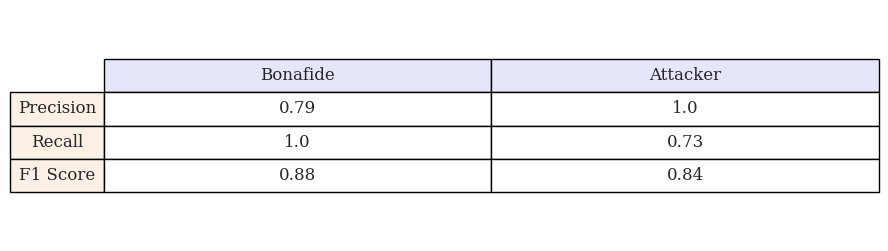

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

model = tf.keras.models.load_model(hyperparams['model_path'])

y_score = model.predict(X_test)

y_predicted = np.argmax(y_score, axis=1)
y_test_argmaxed = np.argmax(y_test, axis=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.PuRd):
    def precision(index):
        return round(cm[index][index] / cm[:, index].sum(),2)

    def recall(index):
        return round(cm[index][index] /cm[index].sum(),2)

    def F1_score(index):
        p=precision(index)
        r=recall(index)
        return round((2 * p * r)/(p + r),2)

    plt.figure(figsize=(6,6), dpi=200)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, 
            round(cm[i, j], 2),
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fig, ax1 = plt.subplots(figsize=(10, 3))

    col_labels = ['Bonafide', 'Attacker']
    row_labels = ['Precision', 'Recall', 'F1 Score']
    row_func = [precision, recall, F1_score]
    table_vals = []

    row_colors = np.full(len(row_labels), 'linen')
    col_colors = np.full(len(col_labels), 'lavender')
    
    for i in range(0, len(row_labels)):
        row = []

        for j in range(0, len(col_labels)):
            row.append(row_func[i](j))

        table_vals.append(row)


    # the rectangle is where I want to place the table
    table = plt.table(cellText=table_vals,
                      cellLoc='center',
                      rowColours=row_colors,
                      rowLabels=row_labels,
                      rowLoc='center',
                      colColours=col_colors,
                      colLabels=col_labels,
                      loc='center')
    table.scale(1, 2)
    ax1.axis('off')

class_names = ["Bonafide", "Attacker"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_argmaxed, y_predicted)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix')